# What's this PyTorch business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, PyTorch (or TensorFlow, if you choose to use that notebook).

### What is PyTorch?

PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation. 

### Why?

* Our code will now run on GPUs! Much faster training. When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry.

### PyTorch versions
This notebook assumes that you are using **PyTorch version 1.0**. In some of the previous versions (e.g. before 0.4), Tensors had to be wrapped in Variable objects to be used in autograd; however Variables have now been deprecated. In addition 1.0 also separates a Tensor's datatype from its device, and uses numpy-style factories for constructing Tensors rather than directly invoking Tensor constructors.

## How will I learn PyTorch?

Justin Johnson has made an excellent [tutorial](https://github.com/jcjohnson/pytorch-examples) for PyTorch. 

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here. If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.


# Table of Contents

This assignment has 5 parts. You will learn PyTorch on **three different levels of abstraction**, which will help you understand it better and prepare you for the final project. 

1. Part I, Preparation: we will use MNIST dataset.
2. Part II, Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors. 
3. Part III, PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define arbitrary neural network architecture. 
4. Part IV, PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a linear feed-forward network very conveniently. 

Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Part I. Preparation

First, we load the MNIST dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In previous parts of the assignment we had to write our own code to download the MNIST dataset, preprocess it, and iterate through it in minibatches; PyTorch provides convenient tools to automate this process for us.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.clip(images*0.3081+0.1307, 0, 1)
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 


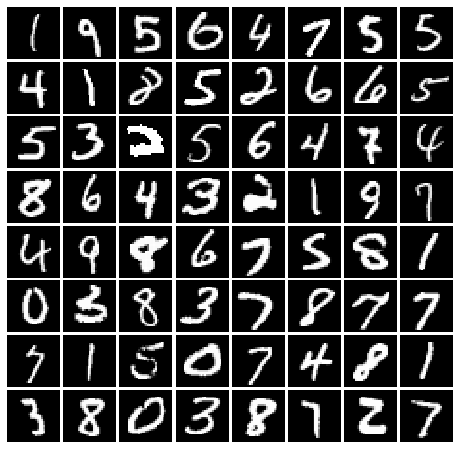

In [2]:
NUM_TRAIN = 55000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform=T.Compose([
               T.ToTensor(),
               T.Normalize((0.1307,), (0.3081,))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the MNIST
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.

mnist_train = dset.MNIST('./data/mnist', train=True, download=True,
                           transform=transform)
loader_train = DataLoader(mnist_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

mnist_val = dset.MNIST('./data/mnist', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(mnist_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 60000)))

mnist_test = dset.MNIST('./data/mnist', train=False, download=True,
                           transform=transform)
loader_test = DataLoader(mnist_test, batch_size=100)

imgs = loader_train.__iter__().next()[0].view(64, 784).numpy().squeeze()
show_images(imgs)


You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Part II. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for MNIST classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

### PyTorch Tensors: Flatten Function
A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Recall that image data is typically stored in a Tensor of shape N x C x H x W, where:

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [4]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [5]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = params
    
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x
    

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

two_layer_fc_test()

torch.Size([64, 10])


### Barebones PyTorch: Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

Note that we have **no softmax activation** here after our fully-connected layer: this is because PyTorch's cross entropy loss performs a softmax activation for you, and by bundling that step in makes computation more efficient.

**HINT**: For convolutions: http://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d; pay attention to the shapes of convolutional filters!

In [6]:
def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 1, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 1, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
    
    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None
    # *****START OF YOUR CODE*****

    x = F.conv2d(x, conv_w1, conv_b1, padding=2)
    x = F.relu(x)
    x = F.conv2d(x, conv_w2, conv_b2, padding=1)
    x = F.relu(x)
    x = flatten(x)
    scores = x.mm(fc_w)+ fc_b

    # *****END OF YOUR CODE*****
    return scores

After defining the forward pass of the ConvNet above, run the following cell to test your implementation.

When you run this function, scores should have shape (64, 10).

In [7]:
def three_layer_convnet_test():
    x = torch.zeros((64, 1, 28, 28), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 1, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 28 * 28, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]
three_layer_convnet_test()

torch.Size([64, 10])


### Barebones PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [8]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU. 
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-1.0156,  0.2617, -0.1916,  1.1661, -0.1474],
        [ 0.0459,  1.2052,  0.5116,  0.9351,  0.5377],
        [-0.2086, -0.3000,  1.1075, -0.3068, -0.1893]], device='cuda:0',
       requires_grad=True)

### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [9]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [10]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on MNIST.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of MNIST has 64 examples, so the tensor shape is `[64, 1, 28, 28]`. 

After flattening, `x` shape should be `[64, 1 * 28 * 28]`. This will be the size of the first dimension of `w1`. 
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

You don't need to tune any hyperparameters but you should see accuracies above 95% after training for one epoch.

In [12]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((1 * 28 * 28, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 2.8664
Checking accuracy on the val set
Got 914 / 5000 correct (18.28%)

Iteration 100, loss = 0.4342
Checking accuracy on the val set
Got 4429 / 5000 correct (88.58%)

Iteration 200, loss = 0.3780
Checking accuracy on the val set
Got 4632 / 5000 correct (92.64%)

Iteration 300, loss = 0.2909
Checking accuracy on the val set
Got 4656 / 5000 correct (93.12%)

Iteration 400, loss = 0.2579
Checking accuracy on the val set
Got 4706 / 5000 correct (94.12%)

Iteration 500, loss = 0.2537
Checking accuracy on the val set
Got 4698 / 5000 correct (93.96%)

Iteration 600, loss = 0.2717
Checking accuracy on the val set
Got 4698 / 5000 correct (93.96%)

Iteration 700, loss = 0.2395
Checking accuracy on the val set
Got 4755 / 5000 correct (95.10%)

Iteration 800, loss = 0.1321
Checking accuracy on the val set
Got 4756 / 5000 correct (95.12%)



### BareBones PyTorch: Training a ConvNet

In the below you should use the functions defined above to train a three-layer convolutional network on MNIST. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy above 96% after one epoch.

In [13]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None

# *****START OF YOUR CODE*****

conv_w1 = random_weight((32, 1, 5, 5))
conv_b1 = zero_weight(32)
conv_w2 = random_weight((16, 32, 3, 3))
conv_b2 = zero_weight(16)
fc_w = random_weight((16*28*28, 10))
fc_b = zero_weight(10)

# *****END OF YOUR CODE*****

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 2.8592
Checking accuracy on the val set
Got 943 / 5000 correct (18.86%)

Iteration 100, loss = 0.4734
Checking accuracy on the val set
Got 4532 / 5000 correct (90.64%)

Iteration 200, loss = 0.4344
Checking accuracy on the val set
Got 4614 / 5000 correct (92.28%)

Iteration 300, loss = 0.2006
Checking accuracy on the val set
Got 4689 / 5000 correct (93.78%)

Iteration 400, loss = 0.3318
Checking accuracy on the val set
Got 4725 / 5000 correct (94.50%)

Iteration 500, loss = 0.1765
Checking accuracy on the val set
Got 4743 / 5000 correct (94.86%)

Iteration 600, loss = 0.2198
Checking accuracy on the val set
Got 4757 / 5000 correct (95.14%)

Iteration 700, loss = 0.2280
Checking accuracy on the val set
Got 4775 / 5000 correct (95.50%)

Iteration 800, loss = 0.0642
Checking accuracy on the val set
Got 4802 / 5000 correct (96.04%)



# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network:

In [14]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # (OPTIONAL) nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init
        # The initialization procedure is optional because it is performed upon 
        # the layer is created. 
        nn.init.kaiming_normal_(self.fc1.weight) # OPTIONAL
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight) # OPTIONAL
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

torch.Size([64, 10])


### Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.

**HINT**: http://pytorch.org/docs/stable/nn.html#conv2d

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [15]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()

        # *****START OF YOUR CODE*****

        self.conv1 = nn.Conv2d(in_channel, channel_1, (5,5), padding=2)
        self.conv2 = nn.Conv2d(channel_1, channel_2, (3,3), padding=1)
        self.fc = nn.Linear(channel_2*28*28, num_classes)
        
        # *****END OF YOUR CODE*****

    def forward(self, x):
        scores = None
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = flatten(x)
        scores = self.fc(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 1, 28, 28), dtype=dtype)  # minibatch size 64, image size [1, 28, 28]
    model = ThreeLayerConvNet(in_channel=1, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([64, 10])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [16]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [17]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on MNIST using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters, but you should see model accuracies above 40% after training for one epoch.

In [18]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(1 * 28 * 28, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part34(model, optimizer)

Iteration 0, loss = 2.9034
Checking accuracy on validation set
Got 1069 / 5000 correct (21.38%)

Iteration 100, loss = 0.3470
Checking accuracy on validation set
Got 4558 / 5000 correct (91.16%)

Iteration 200, loss = 0.3488
Checking accuracy on validation set
Got 4632 / 5000 correct (92.64%)

Iteration 300, loss = 0.4449
Checking accuracy on validation set
Got 4678 / 5000 correct (93.56%)

Iteration 400, loss = 0.2766
Checking accuracy on validation set
Got 4700 / 5000 correct (94.00%)

Iteration 500, loss = 0.3341
Checking accuracy on validation set
Got 4710 / 5000 correct (94.20%)

Iteration 600, loss = 0.1567
Checking accuracy on validation set
Got 4733 / 5000 correct (94.66%)

Iteration 700, loss = 0.1882
Checking accuracy on validation set
Got 4771 / 5000 correct (95.42%)

Iteration 800, loss = 0.1237
Checking accuracy on validation set
Got 4748 / 5000 correct (94.96%)



### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on MNIST. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve about 95% after training for one epoch.

You should train the model using stochastic gradient descent without momentum.

In [19]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

model = None
optimizer = None

# *****START OF YOUR CODE*****

model = ThreeLayerConvNet(1, channel_1, channel_2, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# *****END OF YOUR CODE*****

train_part34(model, optimizer)
check_accuracy_part34(loader_test, model)

Iteration 0, loss = 2.2969
Checking accuracy on validation set
Got 750 / 5000 correct (15.00%)

Iteration 100, loss = 0.4626
Checking accuracy on validation set
Got 4443 / 5000 correct (88.86%)

Iteration 200, loss = 0.6712
Checking accuracy on validation set
Got 4437 / 5000 correct (88.74%)

Iteration 300, loss = 0.4671
Checking accuracy on validation set
Got 4524 / 5000 correct (90.48%)

Iteration 400, loss = 0.4154
Checking accuracy on validation set
Got 4592 / 5000 correct (91.84%)

Iteration 500, loss = 0.3262
Checking accuracy on validation set
Got 4597 / 5000 correct (91.94%)

Iteration 600, loss = 0.3479
Checking accuracy on validation set
Got 4624 / 5000 correct (92.48%)

Iteration 700, loss = 0.2730
Checking accuracy on validation set
Got 4625 / 5000 correct (92.50%)

Iteration 800, loss = 0.3099
Checking accuracy on validation set
Got 4613 / 5000 correct (92.26%)

Checking accuracy on test set
Got 8989 / 10000 correct (89.89%)


# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, you don't need to tune any hyperparameters here, but you shoud achieve above 97% accuracy after one epoch of training.

In [20]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(1 * 28 * 28, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer)

Iteration 0, loss = 2.3133
Checking accuracy on validation set
Got 918 / 5000 correct (18.36%)

Iteration 100, loss = 0.3488
Checking accuracy on validation set
Got 4655 / 5000 correct (93.10%)

Iteration 200, loss = 0.2420
Checking accuracy on validation set
Got 4737 / 5000 correct (94.74%)

Iteration 300, loss = 0.1222
Checking accuracy on validation set
Got 4778 / 5000 correct (95.56%)

Iteration 400, loss = 0.1316
Checking accuracy on validation set
Got 4810 / 5000 correct (96.20%)

Iteration 500, loss = 0.1984
Checking accuracy on validation set
Got 4838 / 5000 correct (96.76%)

Iteration 600, loss = 0.1703
Checking accuracy on validation set
Got 4840 / 5000 correct (96.80%)

Iteration 700, loss = 0.2460
Checking accuracy on validation set
Got 4851 / 5000 correct (97.02%)

Iteration 800, loss = 0.2616
Checking accuracy on validation set
Got 4857 / 5000 correct (97.14%)



### Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You should optimize your model using stochastic gradient descent with Nesterov momentum 0.9.

Again, you don't need to tune any hyperparameters but you should see accuracy about 98% after one epoch of training.

In [21]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

# *****START OF YOUR CODE*****

model = nn.Sequential(
    nn.Conv2d(1, channel_1, (5,5), padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, (3,3), padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(16*28*28, 10),
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,
                      nesterov=True)

# *****END OF YOUR CODE*****

train_part34(model, optimizer)


Iteration 0, loss = 2.2958
Checking accuracy on validation set
Got 843 / 5000 correct (16.86%)

Iteration 100, loss = 0.2096
Checking accuracy on validation set
Got 4780 / 5000 correct (95.60%)

Iteration 200, loss = 0.0694
Checking accuracy on validation set
Got 4848 / 5000 correct (96.96%)

Iteration 300, loss = 0.1591
Checking accuracy on validation set
Got 4897 / 5000 correct (97.94%)

Iteration 400, loss = 0.0198
Checking accuracy on validation set
Got 4882 / 5000 correct (97.64%)

Iteration 500, loss = 0.0399
Checking accuracy on validation set
Got 4918 / 5000 correct (98.36%)

Iteration 600, loss = 0.0159
Checking accuracy on validation set
Got 4917 / 5000 correct (98.34%)

Iteration 700, loss = 0.0996
Checking accuracy on validation set
Got 4917 / 5000 correct (98.34%)

Iteration 800, loss = 0.1975
Checking accuracy on validation set
Got 4911 / 5000 correct (98.22%)



Finally, reguard the above model as the best model and test it with the test set:

In [22]:
best_model = model
check_accuracy_part34(loader_test, best_model)

Checking accuracy on test set
Got 9756 / 10000 correct (97.56%)
